# Machine Learning for Time Series Data in Python

This my class projects about ML applications for time series data from DataCamp.com. There are two ML models: classification model and a regression model.

* Feature extraction: what kinds of spacial features leverage a signal that changes over time?
* model fitting: what kinds of models are suitable for asking questions with timeseries data?
* prediction and validation: how?

Before modeling, you should visualize your data. Histograms and scatterplots are good place to start. Ask these questions:
- Is the data reasonable?
- Are there outliers?
- Are you missing data? 
- Inspect the shape. sklearn need 2D matrix. Use .reshape(-1,1), if your data has just one column.
- Inspect data types

Data with timeseries are:
* audio stored in .wav file: 
    - has sampling rate
    - use librosa library to import the data 
* stock
* pollution/ climate change data 


In [2]:
import sys
sys.path.append(r'C:\Users\Benny\fastai\old')
from fastai.imports import *

import librosa as lr
from glob import glob

# Classification

The first data is a collection of heartbeat sounds from [Kaggle](https://www.kaggle.com/kinguistics/heartbeat-sounds). 
The dataset is split into two sources, A and B:

- set_a.csv - Labels and metadata for heart beats collected from the general public via an iPhone app
- set_a_timing.csv - contains gold-standard timing information for the "normal" recordings from Set A.
- set_b.csv - Labels and metadata for heart beats collected from a clinical trial in hospitals using a digital stethoscope
- audio files - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

2. Heart Sound Classification
The task is to produce a method that can classify real heart audio (also known as “beat classification”) into one of four categories: 'artifact', 'extrahls', 'murmur', 'normal'

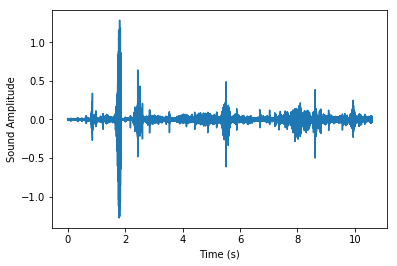

In [7]:
# List all the wav files in the folder
audio_files = glob('heartbeat-sounds/set_b/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

## Feature Engineering 

- Raw time series data is often too noisy for classification. An easy start is work with the data without time dimension. Use the features from the data for classification.
- Add features: min, max, avg as additional features
- Calculate envelop of the time series data, which is rolling average (smoothing) of the absolute waveform. Calculate the statistic of the envelop
- Calculate tempogram, which is the tempo of the sound over time using librosa libary. Then use the summary statistic of the tempo  
- Calculate spectrogram, which is a collection of Fourier transform (FT) of a window, then slice to the next window. The result show how the FT changes over time called short-time Fourier transform (STFT). Extract spectral bandwidth and spectral centroids from the spectrogram. This two features describe where most energy of the sounds is at each moment in time. 

In [3]:
dfa = pd.read_csv('heartbeat-sounds/set_a.csv')
dfb = pd.read_csv('heartbeat-sounds/set_b.csv')

In [6]:
dfa.label.unique(), dfb.label.unique()

(array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object),
 array(['extrastole', 'murmur', 'normal', nan], dtype=object))

# Feature engineer time series data 

To plot raw audio, we need (1) raw audio waveform (2) time point for each sample, which is obtained by dividing the index of each sample by the sampling frequency of timeseries. 

In [65]:
audio_files = glob('heartbeat-sounds/set_a/*.wav')

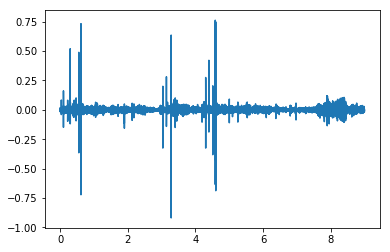

In [72]:
# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[3])
ixs = np.arange(audio.shape[-1])
# divide the index by the sampling frequency
time = ixs / sfreq
fig, ax = plt.subplots()
ax.plot(time, audio)

In [66]:
len(audio_files)

176

In [68]:
dfa.shape

(176, 4)

In [137]:
df = dfa[dfa.label.isin(['extrahls', 'normal'])]

In [142]:
# put all the audio file into a single array each row is one audio file
#only load the file with labeled 'extrahls' and 'normal' 
# the file must have the same size
audio_all = []
df = dfa[dfa.label.isin(['extrahls', 'normal'])]
for i,file in enumerate(df.fname.values):
    audio, sfreq = lr.load('heartbeat-sounds/'+file)
    # only keep the files with the same length
    if audio.shape[0]==198450:
        audio_all.append(audio)
    else:
        df = df.drop(i)

audio_all = np.array(audio_all)
print(audio_all.shape, df.shape)

(17, 198450) (17, 5)


In [148]:
df = df.reset_index()
df['label'].unique()

array(['extrahls', 'normal'], dtype=object)

In [172]:
# feature that can be add as feature 
#treat the problem as normal classification problem
means = np.mean(audio_all,axis=-1)
maxs = np.max(audio_all,axis=-1)
stds = np.std(audio_all,axis=-1)

In [175]:
X = np.column_stack([means,maxs,stds])
X

array([[-0.00004,  0.26929,  0.01313],
       [ 0.00005,  0.31006,  0.02833],
       [ 0.00003,  0.62236,  0.02   ],
       [ 0.00008,  0.12312,  0.01155],
       [ 0.00001,  0.54685,  0.03284],
       [-0.00005,  0.07274,  0.00362],
       [-0.00003,  0.71685,  0.05563],
       [-0.00005,  1.02877,  0.0906 ],
       [ 0.00001,  0.05864,  0.004  ],
       [-0.     ,  0.92448,  0.01   ],
       [-0.00086,  0.50762,  0.08286],
       [-0.00003,  0.17556,  0.00676],
       [ 0.00009,  0.1598 ,  0.01286],
       [ 0.0001 ,  0.96219,  0.02056],
       [-0.00011,  0.34808,  0.03215],
       [-0.00004,  0.41488,  0.03034],
       [ 0.00002,  0.74704,  0.04992]], dtype=float32)

Inspect the waveform of each category

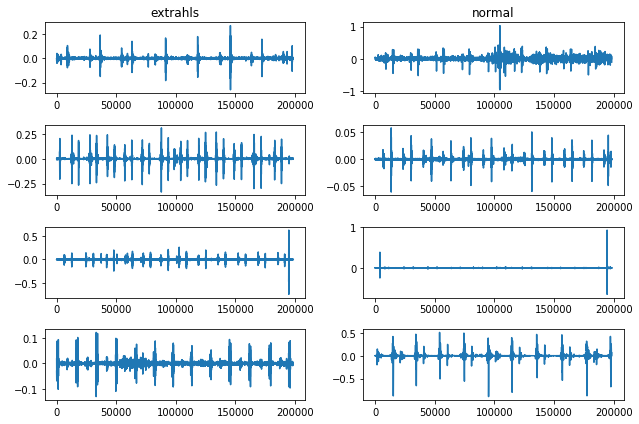

In [151]:
types = df['label'].unique()

fig, ax = plt.subplots(4,2, figsize=(9,6))

for i, label in enumerate(types):
    idxs = df[df['label']==label].index
    ax[0,i].set_title(label)
    for j in range(4):
        ax[j,i].plot(audio_all[idxs[j]])

plt.tight_layout()


In [106]:
ax[0,0]

(3, 4)

Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).

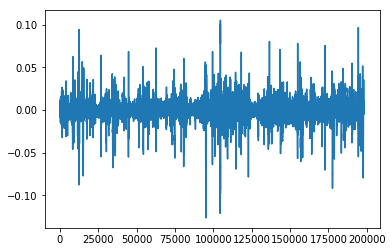

In [156]:
idxs = df[df['label']=='normal'].index

plt.plot(np.mean(audio_all[idxs,:],axis=0))

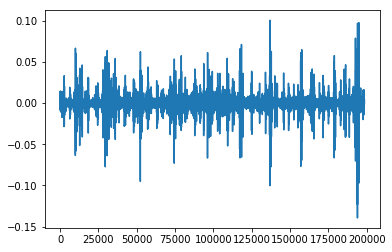

In [157]:
idxs = df[df['label']=='extrahls'].index

plt.plot(np.mean(audio_all[idxs,:],axis=0))

Use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data.

remember sklearn only takes inputs that are 2D array.

In [162]:
from sklearn.model_selection import train_test_split

In [167]:
X_train, X_test, y_train, y_test = train_test_split(audio_all, df.label.values, test_size=0.15, random_state=42,shuffle=True)

In [168]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(14, 198450) (14,)
(3, 198450) (3,)


In [169]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train,y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.0


## Auditory envelope

- rectify the audio by taking absolute
- smooth the data (using rolling window) to calculate the auditory envelope
- related to the total amount of audio energy present at each moment of time 
- rolling function only work for dataframe 

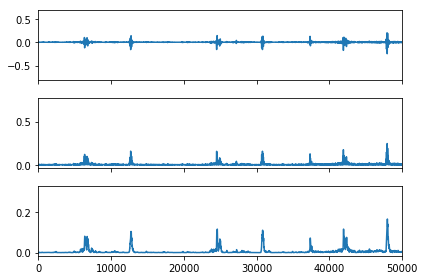

In [193]:
# Smooth our data by taking the rolling mean in a window of 50 samples
window_size = 50
rectified =  pd.DataFrame(audio_all).abs()
audio_envelope = rectified.rolling(window=window_size,min_periods=0,axis=1).mean()

_,ax = plt.subplots(3,1,sharex=True)
i = 2
ax[0].plot(audio_all[i])
ax[0].set(xlim=[0,50000])
ax[1].plot(rectified.iloc[i])
ax[2].plot(audio_smooth.iloc[i])

plt.tight_layout()

In [196]:
# Calculate several features of the envelope, one per sound
envelope_mean = np.mean(audio_envelope, axis=1)
envelope_std = np.std(audio_envelope, axis=1)
envelope_max = np.max(audio_envelope, axis=1)

In [207]:
X = np.column_stack([means,maxs,stds,envelope_mean, envelope_std, envelope_max])
X

array([[-0.00004,  0.26929,  0.01313,  0.0048 ,  0.01092,  0.20596],
       [ 0.00005,  0.31006,  0.02833,  0.00932,  0.02431,  0.27559],
       [ 0.00003,  0.62236,  0.02   ,  0.00672,  0.0164 ,  0.31658],
       [ 0.00008,  0.12312,  0.01155,  0.00478,  0.00946,  0.1052 ],
       [ 0.00001,  0.54685,  0.03284,  0.0143 ,  0.02599,  0.40457],
       [-0.00005,  0.07274,  0.00362,  0.0007 ,  0.00324,  0.05875],
       [-0.00003,  0.71685,  0.05563,  0.02401,  0.04445,  0.73954],
       [-0.00005,  1.02877,  0.0906 ,  0.05735,  0.06821,  0.87159],
       [ 0.00001,  0.05864,  0.004  ,  0.00128,  0.0034 ,  0.04655],
       [-0.     ,  0.92448,  0.01   ,  0.00122,  0.00812,  0.41551],
       [-0.00086,  0.50762,  0.08286,  0.02965,  0.07651,  0.84461],
       [-0.00003,  0.17556,  0.00676,  0.00144,  0.00593,  0.15174],
       [ 0.00009,  0.1598 ,  0.01286,  0.00651,  0.00968,  0.11684],
       [ 0.0001 ,  0.96219,  0.02056,  0.00774,  0.01641,  0.47116],
       [-0.00011,  0.34808,  0.032

Try fitting a classifier using these features

In [200]:
y = df.label.values

In [201]:
from sklearn.model_selection import cross_val_score

In [209]:
model = LinearSVC()
scores = cross_val_score(model, X, y, cv=3) 
print(scores)

[0.57143 0.4     0.8    ]


## Tempogram

The envelope calculation is a common technique in computing tempo and rhythm features. In this exercise, librosa is used to compute some tempo and rhythm features for heartbeat data, and fit a model.

librosa functions tend to only operate on numpy arrays instead of DataFrames

In [203]:
# Import librosa and calculate the tempo of a 1-D sound array
import librosa as lr
audio_tempo = lr.beat.tempo(audio_all[0], sr=sfreq, 
                            hop_length=2**6, aggregate=None)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


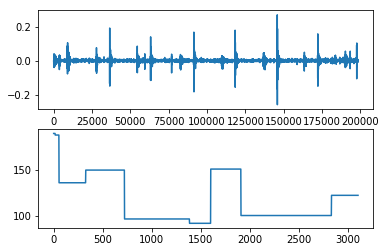

In [230]:
_,ax = plt.subplots(2,1)
ax[0].plot(audio_all[0])
ax[1].plot(audio_tempo)

In [215]:
# Calculate the tempo of each heart beat audio 

# Calculate the tempo of the sounds
tempos = []
for row in audio_all:
    tempos.append(lr.beat.tempo(row, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)
print(tempos.shape)


(17, 3101)


In [290]:
# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=1)
tempos_std = tempos.std(axis=1)
tempos_max = tempos.max(axis=1)

In [223]:
X = np.column_stack([means,maxs,stds,
                     envelope_mean, envelope_std, envelope_max,
                    tempos_mean, tempos_std, tempos_max])
X.shape

(17, 9)

In [226]:
model = LinearSVC()
percent_score = cross_val_score(model, X, y, cv=3)
print(scores)
print(np.mean(percent_score))

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.57143 0.4     0.8    ]
0.5238095238095238


## Spectrogram 

- A spectrogram is a collection of windowed Fourier transforms over time.
- Similar to how a rolling mean was calculated:
    1. Choose a window size and shape
    2. At a timepoint, calculate the FFT for that window
    3. Slide the window over by one
    4. Aggregate the results
- Called a Short-Time Fourier Transform (STFT)
- A spectrogram is a squared of STFT


Here is how to compute a STFT using librosa 

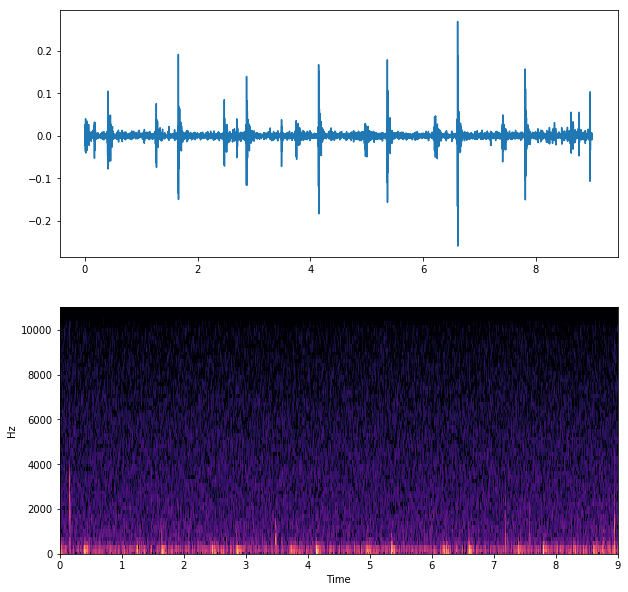

In [257]:
# Import the functions we'll use for the STFT
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow

# Calculate our STFT
HOP_LENGTH = 2**4
SIZE_WINDOW = 2**7
spec = stft(audio_all[0], hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW)

# Convert into decibels for visualization
spec_db = amplitude_to_db(np.abs(spec))

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ixs = np.arange(audio_all[0].shape[-1])
# divide the index by the sampling frequency
time = ixs / sfreq
axs[0].plot(time,audio_all[0])
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH,ax=axs[1])


## Spectral feature engineering

- Each timeseries has a different spectral pattern.
- We can calculate these spectral patterns by analyzing the spectrogram.
- For example, spectral bandwidth and spectral centroids describe where most of the energy is at each moment in time

from the spectogram above, I can calculate the bandwidth and centroids

In [277]:
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=np.abs(spec))[0]
centroids = lr.feature.spectral_centroid(S=np.abs(spec))[0]

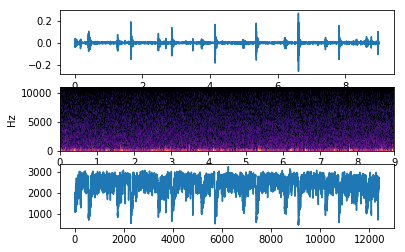

In [279]:
_,axs = plt.subplots(3,1)
ixs = np.arange(audio_all[0].shape[-1])
# divide the index by the sampling frequency
time = ixs / sfreq
axs[0].plot(time,audio_all[0])
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH,ax=axs[1])
axs[2].plot(bandwidths)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\librosa\core\spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


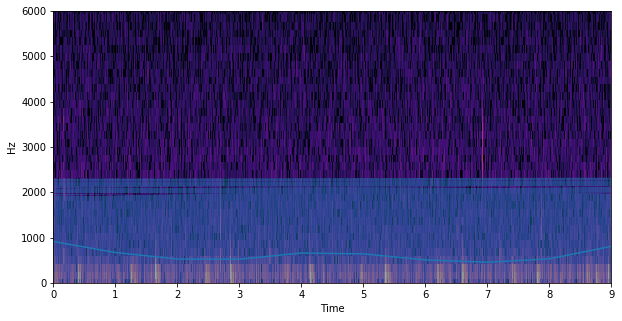

In [278]:
# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.plot( centroids)
ax.fill_between(centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

Compute the centroids and bandwidths for all audio files

In [284]:
spectrograms = []
for audio_array in audio_all:
    spec = stft(audio_array, hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW)
    spectrograms.append(spec)

In [285]:
len(spectograms)

17

In [286]:
spectrograms[0].shape

(65, 12404)

In [288]:
centroids_all = []
bandwidths_all = []
for spec in spectrograms:
    bandwidth = lr.feature.spectral_bandwidth(S=lr.db_to_amplitude(np.abs(spec)))
    centroid = lr.feature.spectral_centroid(S=lr.db_to_amplitude(np.abs(spec)))
    # Calculate the mean spectral bandwidth
    bandwidths_all.append(np.mean(bandwidth))  
    # Calculate the mean spectral centroid
    centroids_all.append(np.mean(centroid))  



In [292]:
# Create our X matrix
X = np.column_stack([means, stds, maxs, 
                     envelope_mean, envelope_std, envelope_max,
                    tempos_mean, tempos_std, tempos_max,
                     bandwidths_all, centroids_all])

In [294]:
percent_score = cross_val_score(model, X, y, cv=3)
print(scores)
print(np.mean(percent_score))

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.57143 0.4     0.8    ]
0.5238095238095238


# Predicting data over time (Regression)

The next dataset contains information about company market value over several years of time.  If you can model the value of a company as it changes over time, you can make predictions about where that company will be in the future. This dataset also from Kaggle [competition](https://www.kaggle.com/dgawlik/nyse).

Dataset consists of following files:

* prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
* prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
* securities.csv: general description of each company with division on sectors
* fundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.

**Correlation and regression** 

Regression is similar to calculating correlation, with some key differences
- Regression: A process that results in a formal model of the data
- Correlation: A statistic that describes the data. Less information than regression model.

## Start with visualization 

- plot the data over time
- check if two series are correlated using scatter plot 

In [337]:
# Read in the data
data = pd.read_csv('data-nyse/prices-split-adjusted.csv')
data=pd.pivot_table(data,index='date',columns='symbol',values='close',
              aggfunc='mean')
data=data[['AAPL', 'FB', 'NFLX', 'V', 'XOM','EBAY','NVDA','YHOO']].dropna(how='all')
data.index = pd.to_datetime(data.index)
data.head()

symbol,AAPL,FB,NFLX,V,XOM,EBAY,NVDA,YHOO
date,,,,,,,,
2010-01-04,30.572857,NaN,7.640000,22.035000,69.150002,10.058923,18.490000,17.100000
2010-01-05,30.625713,NaN,7.358572,21.782499,69.419998,9.953704,18.760000,17.230000
2010-01-06,30.138571,NaN,7.617143,21.490000,70.019997,9.890572,18.879999,17.170000
2010-01-07,30.082857,NaN,7.485714,21.690001,69.800003,9.776935,18.510000,16.700001
2010-01-08,30.282858,NaN,7.614286,21.750000,69.519997,9.894781,18.549999,16.700001


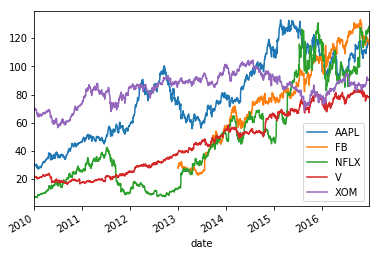

In [300]:
# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)

# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data.columns:
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()


**Visualizing relationships between timeseries**


[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Color = time')]

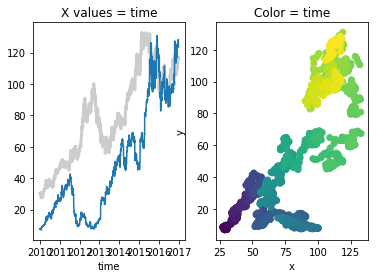

In [301]:
ig, axs = plt.subplots(1, 2)

# Make a line plot for each timeseries
axs[0].plot(data.AAPL, c='k', lw=3, alpha=.2)
axs[0].plot(data.NFLX)
axs[0].set(xlabel='time', title='X values = time')

# Encode time as color in a scatterplot
axs[1].scatter(data.AAPL,data.NFLX, c=np.arange(len(data.AAPL)), cmap='viridis')
axs[1].set(xlabel='x', ylabel='y', title='Color = time')

## Regression with Sklearn

Scoring regression models
Two most common methods:
- Correlation (r)
- Coefficient of Determination (R$^2$)

In [336]:
# try a simple linear regression 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [323]:
X = data['AAPL'].reset_index().index.astype(float).values.reshape((-1,1))
y = data.AAPL.values
model = LinearRegression()
model.fit(X, y)
model.predict(X)

array([ 35.61656,  35.66629,  35.71602, ..., 123.08935, 123.13908, 123.1888 ])

Ridge regression with different hyper parameters and visualize goodness of fit

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42)

In [327]:
type(y_train[0])

numpy.float64

[(0, 100)]

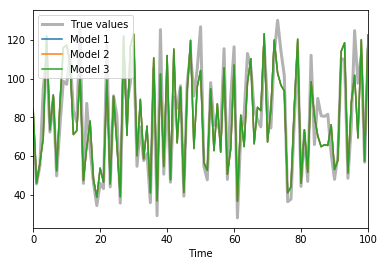

In [335]:
from matplotlib import cm

alphas = [.1, 1e2, 1e3]
_,ax = plt.subplots()
ax.plot(y_test, color='k', alpha=.3, lw=3)
for ii, alpha in enumerate(alphas):
    y_predicted = Ridge(alpha=alpha).fit(X_train, y_train).predict(X_test)
    ax.plot(y_predicted)
ax.legend(['True values', 'Model 1', 'Model 2', 'Model 3'])
ax.set(xlabel="Time")
ax.set(xlim=[0,100])


In [338]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = data[['EBAY','NVDA','YHOO']]
y = data[['AAPL']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-0.57572 -3.77871 -5.46035]


**Visualizing predicted values**

In [354]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = np.concatenate(predictions)
score = r2_score(y_test, predictions)
print(score)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


-43.478122773063305


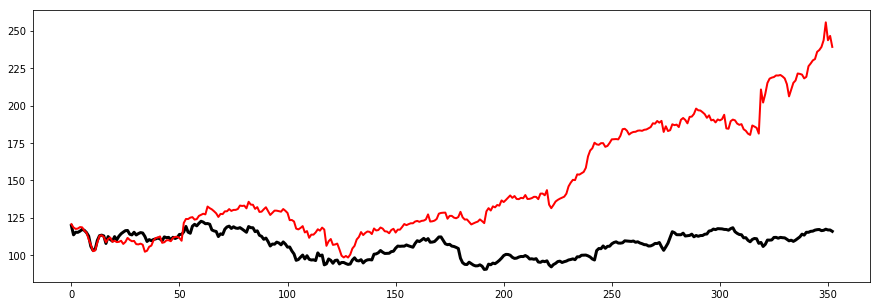

In [356]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.values, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
#plt.show()

## Clean the data

- Interpolation : fill the missing data with known values 
- Rolling window 
- Transform data to standardize variance 
- Transform data to make each point represent the % change over a previous window. Make timepoints more comparable to another if the absolute values change a lot. This can also be used to detect outliers.
- replace or remove outliers, which is outside a threshold. Note requires careful consideration. Here, I will replace the outliers with the median.

In [417]:
# Read in the data, which is not perfect
data = pd.read_csv('data-nyse/prices.csv')
data=pd.pivot_table(data,index='date',columns='symbol',values='close',
              aggfunc='mean')
data=data[['AAPL', 'FB', 'NFLX', 'V', 'XOM','EBAY','NVDA','YHOO','AIG','ABT']].dropna(how='all')
data.index = pd.to_datetime(data.index)
data.head()

symbol,AAPL,FB,NFLX,V,XOM,EBAY,NVDA,YHOO,AIG,ABT
date,,,,,,,,,,
2010-01-04,214.009998,NaN,53.479999,88.139999,69.150002,23.900000,18.490000,17.100000,29.889999,54.459951
2010-01-05,214.379993,NaN,51.510001,87.129997,69.419998,23.650000,18.760000,17.230000,29.330000,54.019953
2010-01-06,210.969995,NaN,53.319999,85.959999,70.019997,23.500000,18.879999,17.170000,29.139999,54.319953
2010-01-07,210.580000,NaN,52.400001,86.760002,69.800003,23.229998,18.510000,16.700001,28.580000,54.769952
2010-01-08,211.980005,NaN,53.300002,87.000000,69.519997,23.509999,18.549999,16.700001,29.340000,55.049952


### Interpolation in Pandas 


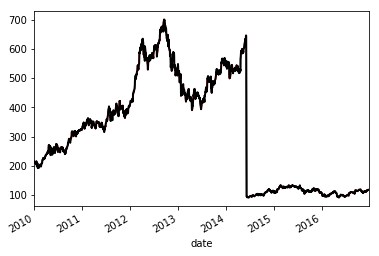

In [394]:
# Return a boolean that notes where missing values are
missing = data['AAPL'].isna()

# Interpolate linearly within missing windows
prices_interp = data['AAPL'].interpolate('linear')

# Plot the interpolated data in red and the data w/ missing values in black
ax = prices_interp.plot(c='r')
data['AAPL'].plot(c='k', ax=ax, lw=2)

### Using a rolling window to transform data 

Another common use of rolling windows is to transform the data. 

**Transforming data to standardize variance** 
- A common transformation to apply to data is to standardize its mean and variance over time. There are many ways to do this.
- EX. convert your dataset so that each point represents the % change over a previous window. This makes timepoints more comparable to one another if the absolute values of data change a lot. This is useful for finding outliers

Outliers is often defined as a datapoint, which is 3 std away from the mean of the dataset.

In [368]:
def percent_change(values):
    """Calculates the % change between the last value 
    and the mean of previous values"""
    # Separate the last value and all previous values into variables
    previous_values = values[:-1]
    last_value = values[-1]

    # Calculate the % difference between the last value 
    # and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) \
    / np.mean(previous_values)
    return percent_change

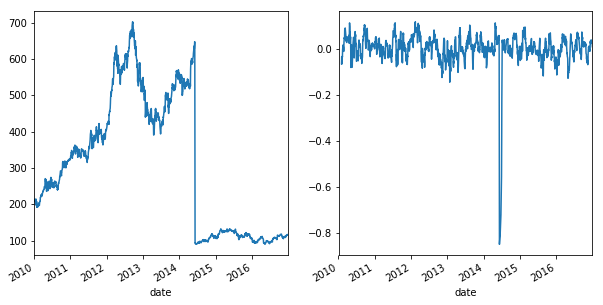

In [395]:
# Plot the raw data
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = data['AAPL'].plot(ax=axs[0])

# Calculate % change and plot
ax = data['AAPL'].rolling(window=20).aggregate(percent_change).plot(ax=axs[1])

the data on the right is center around zero and period with large changes are easier to spot.

Now we visualize outliers (datapoints, which are 3 std away from the mean)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


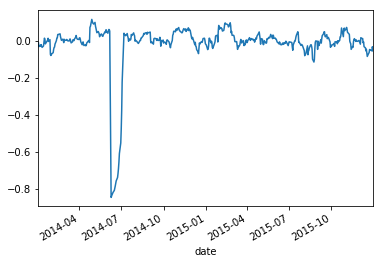

In [400]:
# Apply your custom function and plot
prices_perc =  data['AAPL'].rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

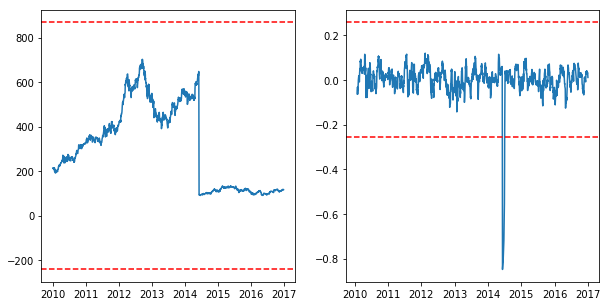

In [396]:
prices = data['AAPL']
prices_perc_change = prices.rolling(window=20).aggregate(percent_change)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for temp, ax in zip([prices, prices_perc_change], axs):
    # Calculate the mean / standard deviation for the data
    this_mean = np.mean(temp)
    this_std = np.std(temp)

    # Plot the data, with a window that is 3 standard deviations 
    # around the mean
    ax.plot(temp)
    ax.axhline(this_mean + this_std * 3, ls='--', c='r')
    ax.axhline(this_mean - this_std * 3, ls='--', c='r')

**Replacing outliers using the threshold**


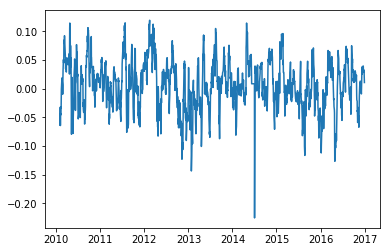

In [398]:
# Center the data so the mean is 0
prices_outlier_centered = prices_perc_change - prices_perc_change.mean()

# Calculate standard deviation
std = prices_perc_change.std()

# Use the absolute value of each datapoint 
# to make it easier to find outliers
outliers = np.abs(prices_outlier_centered) > (std * 3)

# Replace outliers with the median value
# We'll use np.nanmean since there may be nans around the outliers
prices_outlier_fixed = prices_outlier_centered.copy()
prices_outlier_fixed[outliers] = np.nanmedian(prices_outlier_fixed)
# look at the data after fixing outliers
plt.plot(prices_outlier_fixed)

In [402]:
type(prices_perc)

pandas.core.series.Series

In [ ]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

In [ ]:
# Count the missing values of each time series
missing_values = df.isna().sum()
print(missing_values)

In [399]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

In [ ]:
# Interpolate using the latest non-missing value
#type options: 'zero','linear','quadratic'
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

## Feature Engineers

- using rolling windows  
- add features such as std, min, max, avg, percentiles
- add date-based feature such as weekend, weekday, holidays that include human features.

Note: we will take advantage of "partial" function, which create another function from the old one. 


In [406]:
feats = data[['AIG','ABT']].rolling(20).aggregate([np.std, np.max]).dropna()
feats.head()

AIG                  ABT           
                 std       amax       std       amax
date                                                
2010-02-01  2.051966  29.889999  0.868830  56.239949
2010-02-02  2.101032  29.629999  0.869197  56.239949
2010-02-03  2.157249  29.629999  0.852509  56.239949
2010-02-04  2.282004  29.629999  0.873895  56.239949
2010-02-05  2.400626  29.629999  0.891497  56.239949

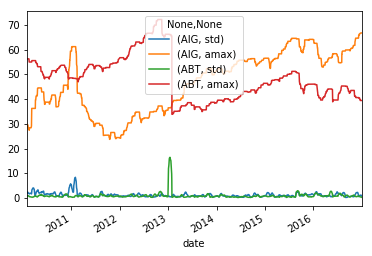

In [407]:
feats.plot()

In [408]:
from functools import partial

In [410]:
# example of a partial function
# If we just take the mean, it returns a single value
a = np.array([[0, 1, 2], [0, 1, 2], [0, 1, 2]])
print(np.mean(a))
1.0

# We can use the partial function to initialize np.mean 
# with an axis parameter
from functools import partial
mean_over_first_axis = partial(np.mean, axis=0)
print(mean_over_first_axis(a))

1.0
[0. 1. 2.]


In [416]:
#combine np.percencile() with partial functions 

temp = np.linspace(0, 100)

# Create a list of functions using a list comprehension
percentile_funcs = [partial(np.percentile, q=ii) for ii in [20, 40, 60]]

# Calculate the output of each function in the same way
percentiles = [i_func(data) for i_func in percentile_funcs]
print(percentiles)
[20.0, 40.00000000000001, 60.0]

# Calculate multiple percentiles of a rolling window
pd.DataFrame(temp).rolling(20).aggregate(percentile_funcs).tail()

[20.0, 40.00000000000001, 60.0]


0                      
   percentile percentile percentile
45  60.816327  68.571429  76.326531
46  62.857143  70.612245  78.367347
47  64.897959  72.653061  80.408163
48  66.938776  74.693878  82.448980
49  68.979592  76.734694  84.489796

**datetime features using Pandas**

In [419]:
# Ensure our index is datetime
prices.index = pd.to_datetime(prices.index)

# Extract datetime features
day_of_week_num = prices.index.weekday
print(day_of_week_num[:10])

day_of_week = prices.index.weekday_name
print(day_of_week[:10])


Int64Index([0, 1, 2, 3, 4, 0, 1, 2, 3, 4], dtype='int64', name='date')
Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype='object', name='date')


In [420]:
# Apply your custom function and plot
prices_perc =  data['AAPL'].rolling(20).apply(percent_change)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


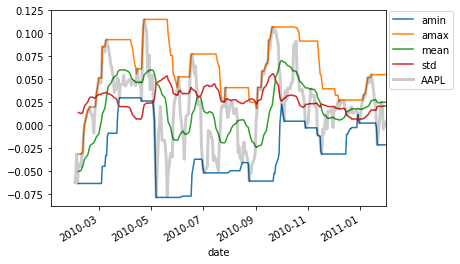

In [421]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.agg(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

In [422]:
features.head()

,amin,amax,mean,std
date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN


practice how calculate Percentiles and partial functions

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


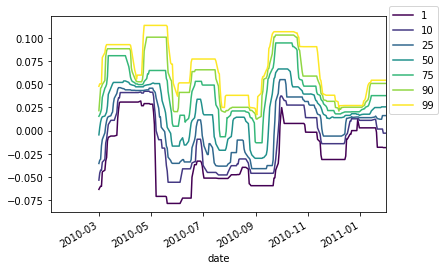

In [423]:
# Import partial from functools
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.agg(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

In [443]:
prices_perc = prices.rolling(window=20).aggregate(percent_change)

In [449]:
prices_perc = pd.DataFrame(prices_perc)
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.week
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
prices_perc.head()

,AAPL,day_of_week,week_of_year,month_of_year
date,,,,
2010-01-04,NaN,0,1,1
2010-01-05,NaN,1,1,1
2010-01-06,NaN,2,1,1
2010-01-07,NaN,3,1,1
2010-01-08,NaN,4,1,1


### Time-delayed features and auto-regressive models 

use information in the past to predict the future values 

Questions to ask:
- how smooth is the data?
- how correlated is a time point with its neighboring timepoints? (autocorrelation).
- the amount of auto-correlation in data will impact your models

Analysis procedure:
- create a time-shifted df 
- fit a model using x=shifted data and y is data
- large absolute value of coefficients mean that a feature has large impact of the output variable 

### Auto-regressive models
Auto-regressive model is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

In [472]:
# Read in the df
df = pd.read_csv('data-nyse/prices-split-adjusted.csv')
df=pd.pivot_table(df,index='date',columns='symbol',values='close',
              aggfunc='mean')
df=df[['AAPL', 'FB', 'NFLX', 'V', 'XOM','EBAY','NVDA','YHOO','AIG']].dropna(how='all')
df.index = pd.to_datetime(df.index)
df.head()

symbol,AAPL,FB,NFLX,V,XOM,EBAY,NVDA,YHOO,AIG
date,,,,,,,,,
2010-01-04,30.572857,NaN,7.640000,22.035000,69.150002,10.058923,18.490000,17.100000,29.889999
2010-01-05,30.625713,NaN,7.358572,21.782499,69.419998,9.953704,18.760000,17.230000,29.330000
2010-01-06,30.138571,NaN,7.617143,21.490000,70.019997,9.890572,18.879999,17.170000,29.139999
2010-01-07,30.082857,NaN,7.485714,21.690001,69.800003,9.776935,18.510000,16.700001,28.580000
2010-01-08,30.282858,NaN,7.614286,21.750000,69.519997,9.894781,18.549999,16.700001,29.340000


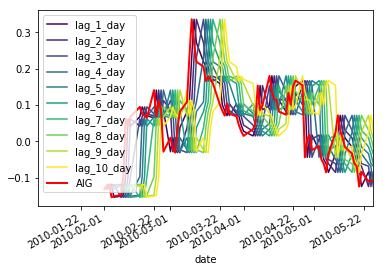

In [477]:
# data is a pandas Series containing time series data
data = df['AIG']
prices_perc = data.rolling(window=20).aggregate(percent_change)

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)
# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()
#data = data.iloc[-many_shifts.shape[0]:]

### Auto-regressive models

Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [479]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

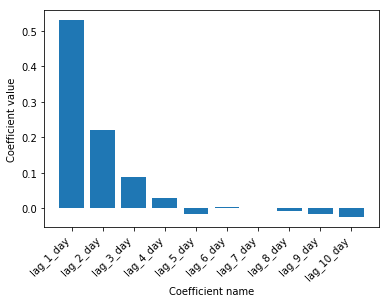

In [482]:
# Visualize the fit model coefficients
fig, ax = plt.subplots()
ax.bar(prices_perc_shifted.columns, model.coef_)
ax.set(xlabel='Coefficient name', ylabel='Coefficient value')

# Set formatting so it looks nice
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

**Visualize regression coefficients**


In [483]:
# create a function that, given a set of coefficients and feature names,
# visualizes the coefficient values.
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

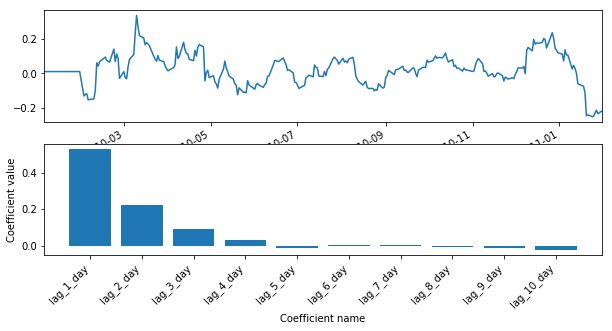

In [484]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

Auto-regression with a smoother time series
Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. 

In [485]:
# data is a pandas Series containing time series data
data = df['AIG']
prices_perc = data.rolling(window=40).aggregate(percent_change)

# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

In [486]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

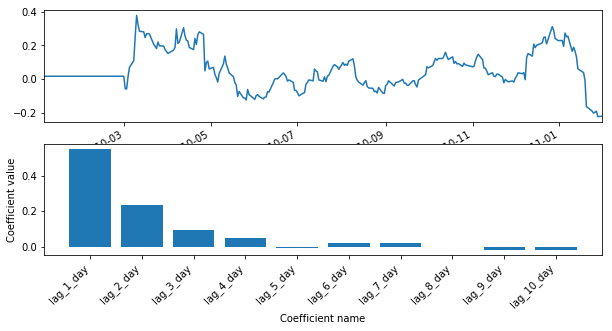

In [487]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

The the correlation coefficient went down slower. The model is not i.i.d.

# Cross-validating time series data

Most common type of cross validation is KFold. KFold cross-validation splits 

- always visualize the model behavior during cross-validation
- Cannot randomly shuffle time series data for cross validation
- randomly shuffle data only work if the data is not i.i.d
- Use training data from the past to predict the future 
- Use `TimeSeriesSplit` in sklearn 


**Cross-validation without shuffling**


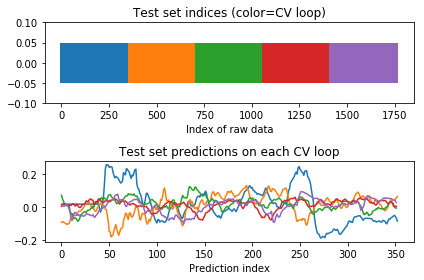

In [499]:
# Examples 
    
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)
model = Ridge()

fig, axs = plt.subplots(2, 1)

for tr, tt in cv.split(X, y):
    model.fit(X.iloc[tr], y[tr])
    model.score(X.iloc[tt], y[tt])

    
    # Plot the indices chosen for validation on each loop
    axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
    axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)', 
           xlabel='Index of raw data')
    # Plot the model predictions on each iteration
    axs[1].plot(model.predict(X.iloc[tt]))
    axs[1].set(title='Test set predictions on each CV loop', 
           xlabel='Prediction index')
    
plt.tight_layout()

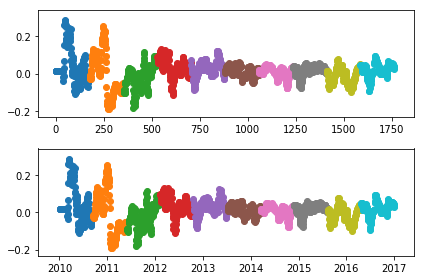

In [518]:
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
fig, axs = plt.subplots(2, 1)
coeff_all = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X.iloc[tr], y[tr])
    coeff_all.append(model.coef_)
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X.iloc[tt])

    results.append((prediction, tt))
    # Plot the model prediction vs iteration number 
    axs[0].scatter(tt,model.predict(X.iloc[tt]))

    # Plot the model predictions vs time 
    axs[1].scatter(X.index[tt],model.predict(X.iloc[tt]))
    
plt.tight_layout()

The split without shuffling look better than the shuffle example below. It looks more like a time series data. It is smoother.

**Cross-validation with shuffling**

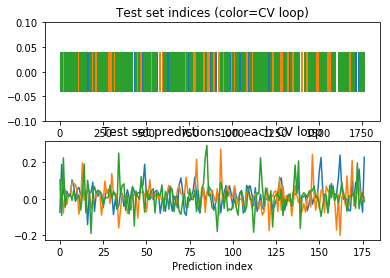

In [498]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=3,random_state=1)
model = Ridge()
fig, axs = plt.subplots(2, 1)

for tr, tt in cv.split(X, y):
    model.fit(X.iloc[tr], y[tr])
    model.score(X.iloc[tt], y[tt])

    # Plot the indices chosen for validation on each loop
    axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
    axs[0].set(ylim=[-.1, .1], title='Test set indices (color=CV loop)', 
           xlabel='Index of raw data')
    # Plot the model predictions on each iteration
    axs[1].plot(model.predict(X.iloc[tt]))
    axs[1].set(title='Test set predictions on each CV loop', 
           xlabel='Prediction index')

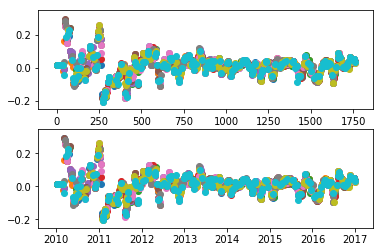

In [513]:
cv = ShuffleSplit(10, random_state=1)

# Iterate through CV splits
results = []
fig, axs = plt.subplots(2, 1)
coeff_all = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X.iloc[tr], y[tr])
    coeff_all.append(model.coef_)
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X.iloc[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))
    # Plot the model prediction vs iteration number 
    axs[0].scatter(tt,model.predict(X.iloc[tt]))
    # Plot the model predictions vs time 
    axs[1].scatter(X.index[tt],model.predict(X.iloc[tt]))

In [504]:
X.head()

,lag_1_day,lag_2_day,lag_3_day,lag_4_day,lag_5_day,lag_6_day,lag_7_day,lag_8_day,lag_9_day,lag_10_day
date,,,,,,,,,,
2010-01-04,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123
2010-01-05,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123
2010-01-06,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123
2010-01-07,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123
2010-01-08,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123,0.017123


**Time-based cross-validation** 

Visualizing time series cross validation iterators

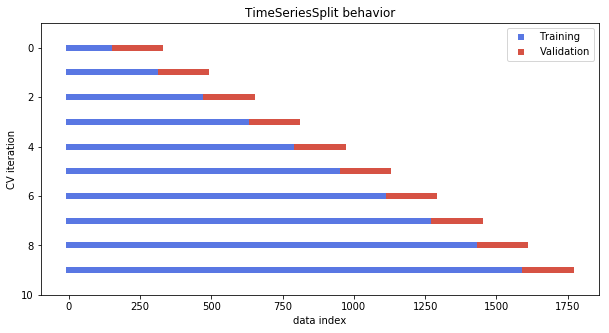

In [488]:
# Import and initialize the cross-validation iterator
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot training and test indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], 
                    marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], 
                    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', 
           xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

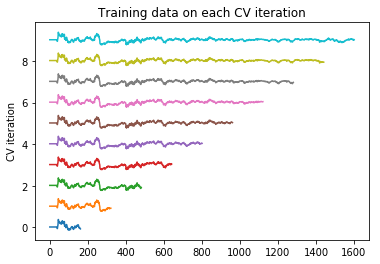

In [514]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Custom scoring functions in scikit-learn. Take an estimator object, X,y and output a single numerber. Belows are examples.

In [ ]:
def myfunction(estimator, X, y):
    y_pred = estimator.predict(X)
    my_custom_score = my_custom_function(y_pred, y)
    return my_custom_score

In [ ]:
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector 
    y_pred = est.predict(X).squeeze()

    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())

    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef

# Stationarity 

- Stationary time series do not change their properties over time (mean, std, trends)
- most time series are non-stationary to some extent 
- model parameters may change over time. How to know if the data is non-stationary signal ?

   - Method 1: quantify model parameters is to use (2) cross-validation, (2) calculate the model parameter for each iteration, and (3) assess parameter stability across all CV splits 
   - Method 2: use boostrap the coeff for each split: (1) take a random sample of the coefficients with replacement, (2) calculate the mean of the sample, (3) repeat this process many time(1000s), (4) calculate the percentiles of the result (2.5 and 97.5). The results is a 95% confident interval of the mean of each coefficients. 
   - Method 3: use timeseriessplit, and keep track of the splitting time index. Plot the cross validation score vs time index to see how the predictive power change for each split. 
   
   
If after method 3, we learn that the score decreases for certain time period, we can fix the model using the following methods:
   - fixed a time window by passing max_train_size=window_size 
   

**Bootstrapping a confidence interval**

A useful tool for assessing the variability of some data is the bootstrap.


In [521]:
len(coeff_all)

10

In [526]:
from sklearn.utils import resample

# cv_coefficients has shape (n_cv_folds, n_coefficients)
n_boots = 100
n_coefficients = len(coeff_all)
cv_coefficients = coeff_all
bootstrap_means = np.zeros((n_boots, n_coefficients))
for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, 
    # then take the sample mean
    random_sample = resample(cv_coefficients)
    random_sample = np.array(random_sample)
    bootstrap_means[ii] = random_sample.mean(axis=0)

# Compute the percentiles of choice for the bootstrapped means
# 95% confident interval
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

In [530]:
X.columns

Index(['lag_1_day', 'lag_2_day', 'lag_3_day', 'lag_4_day', 'lag_5_day',
       'lag_6_day', 'lag_7_day', 'lag_8_day', 'lag_9_day', 'lag_10_day'],
      dtype='object')

In [529]:
percentiles.shape

(2, 10)

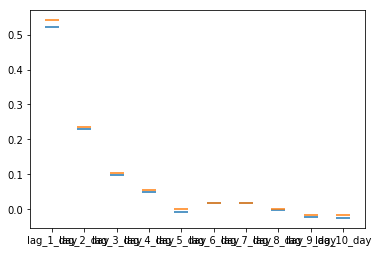

In [537]:
ig, ax = plt.subplots()
ax.scatter(X.columns, percentiles[0], marker='_', s=200)
ax.scatter(X.columns, percentiles[1], marker='_', s=200)


write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: a 2-D array of numbers (data), a list of percentiles to calculate (percentiles), and the number of boostrap iterations to use (n_boots). It uses the resample function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

In [540]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [542]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X.iloc[tr], y[tr])
    coefficients[ii] = model.coef_

In [565]:
coefficients.shape

(100, 10)

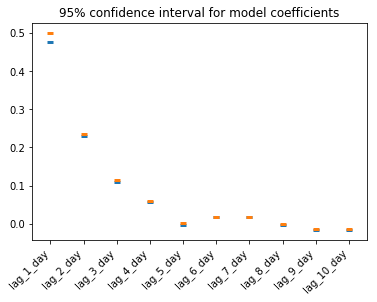

In [544]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(X.columns, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(X.columns, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**Assessing model performance stability (Model performance over time)**

- If using the TimeSeriesSplit, can plot the model's score over time.
- This is useful in finding certain regions of time that hurt the score
- Also useful to find non-stationary signals
- Visualizing model scores as a timeseries
- If see a change in the predictive power at one moment in time. This means the statistic of data have change.

In [538]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient 
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]

# Create time-series cross-validation object
cv = TimeSeriesSplit(10)

# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]

# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)

Visualizing model scores as a timeseries. If see a change in the predictive power at one moment in time. This means the statistic of data have change.

[Text(0.5, 1.0, 'Validation data')]

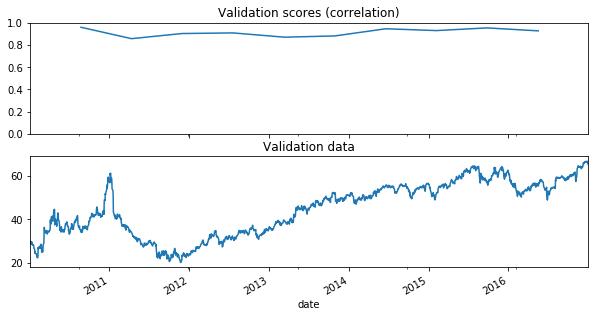

In [539]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])

# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

If some dip in the validation is seen, then we can try to fixed windows with time series cross-validation to ensures that only the latest datapoints are used in training. This is a parameter in the TimeSeriesSplit.

In [ ]:
# Only keep the last 100 datapoints in the training data
window = 100

# Initialize the CV with this window size
cv = TimeSeriesSplit(n_splits=10, max_train_size=window)

Visualizing model score variability over time. 

In [548]:
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector 
    y_pred = est.predict(X).squeeze()

    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())

    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef

In [561]:
scores.shape

(100,)

In [563]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Grab the date of the first index of each validation set
times_scores = [X.index[tt[0]] for tr, tt in cv.split(X, y)]

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')


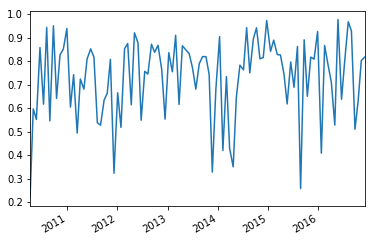

In [562]:
scores_series.plot()

In [573]:
def bootstrap_interval(data, percentiles=2.5, n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create our empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)
        
    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [ ]:
# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

In [555]:
scores_series.index

DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
      

In [ ]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

In [557]:
#Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

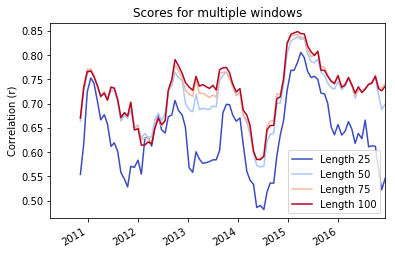

In [558]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()